In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 100)
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [4]:
df_ta_BTC = pd.read_excel('../Crypto_data/BITCOIN_Data.xlsx')
df_ta_SHIB = pd.read_excel('../Crypto_data/SHIBAINU_Data.xlsx')
df_ta_SOL = pd.read_excel('../Crypto_data/SOLANA_Data.xlsx')
df_ta_ETH = pd.read_excel('../Crypto_data/ETHEREUM_Data.xlsx')
df_ta_LINK = pd.read_excel('../Crypto_data/CHAINLINK_Data.xlsx')
df_ta_DOGE = pd.read_excel('../Crypto_data/DOGECOIN_Data.xlsx')

In [5]:
def preprocessing(data):
    data.rename(columns={'Datum':'Date', 'Eröffn.':'Open', 'Hoch':'High',
                     'Tief':'Low', 'Vol.':'Volume', 'Zuletzt':'Close'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
    data.drop('+/- %', axis=1, inplace=True)
    data.sort_values('Date', inplace=True)
    data.reset_index(drop=True, inplace=True)

    
#     for column in data.drop(columns=['Date', 'Volume']).columns:
#         data[column] = [float(str(i).replace(",", "")) for i in data[column]]
        
    data['Volume'] = [str(i).replace(",", "") for i in data['Volume']]
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    

    def value_to_float(x):
        if type(x) == float or type(x) == int:
            return x
        if 'K' in x:
            if len(x) > 1:
                return float(x.replace('K', '')) * 1000
            return 1000.0
        if 'M' in x:
            if len(x) > 1:
                return float(x.replace('M', '')) * 1000000
            return 1000000.0
        if 'B' in x:
            return float(x.replace('B', '')) * 1000000000
        return 0.0

    data['Volume'] = data['Volume'].apply(value_to_float)
    data['Volume'] = data['Volume'] / 1000.0

    
    data_training = data[data['Date'] < '2021-06-01'].copy()
    data_test = data[data['Date'] > '2021-06-01'].copy()
    
    training_data = data_training.drop(['Date'], axis = 1)
    
    # MinMaxScaler is used to normalize the data
    scaler = MinMaxScaler()
    training_data = scaler.fit_transform(training_data)
    training_data
    
    X_train = [] 
    Y_train = []
    
    for i in range(60, training_data.shape[0]):
        X_train.append(training_data[i-60:i])   
        Y_train.append(training_data[i,0])
    
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    return data_test, data_training, data, X_train, Y_train, scaler

In [6]:
def training(X_train, Y_train):
    #Initialize the RNN
    model = Sequential() 
    model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], len(X_train[0][0]))))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.4)) 
    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units =1))
    model.summary()
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(X_train, Y_train, epochs = 20, batch_size = 50, 
                        validation_split = 0.1)
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
    return model

In [7]:
def prediction(model, data_training, data_test, scaler, curr):
    part_60_days = data_training.tail(60)
    df = part_60_days.append(data_test, ignore_index = True)
    df_backup = df.copy()
    df = df.drop(['Date'], axis = 1)
    df.head()
    
    inputs = scaler.transform(df)
    
    X_test = []
    Y_test = []
    
    for i in range (60, inputs.shape[0]):
        X_test.append(inputs[i-60:i])
        Y_test.append(inputs[i, 0])

    X_test, Y_test = np.array(X_test), np.array(Y_test) 
    
    Y_pred = model.predict(X_test)
    
    scale = 1/scaler.scale_[0]
    Y_test = Y_test*scale
    Y_pred = Y_pred*scale
    
    df_backup_cut = df_backup[-190:]
    df_backup_cut['Prediction'] = Y_pred
    df_backup_cut['Actual'] = Y_test
    
    y1 = df_backup_cut['Prediction']
    y2 = df_backup_cut['Actual']

    x = df_backup_cut['Date']
    y1 = df_backup_cut['Prediction']
    y2 = df_backup_cut['Actual']
    
    fig, ax = plt.subplots(figsize=(14,5))

    ax.plot(x,y2, color = 'red', label = 'Real '+ curr + ' Price')
    ax.plot(x,y1, color = 'green', label = 'Predicted '+ curr + ' Price')

    ax.set_title(curr +' Price Prediction using RNN-LSTM')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.grid()
    
    plt.savefig('figures/'+curr +' Price Prediction using RNN-LSTM.png')
    plt.show()
    
    return df_backup_cut

In [8]:
def full_prediction_workflow(data, curr):
    data_test, data_training, data, X_train, Y_train, scaler = preprocessing(data)
    model = training(X_train, Y_train)
    df_backup_cut = prediction(model, data_training, data_test, scaler, curr)
    
    return df_backup_cut

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

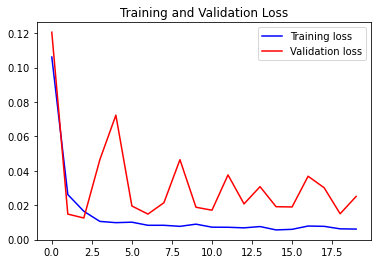

C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


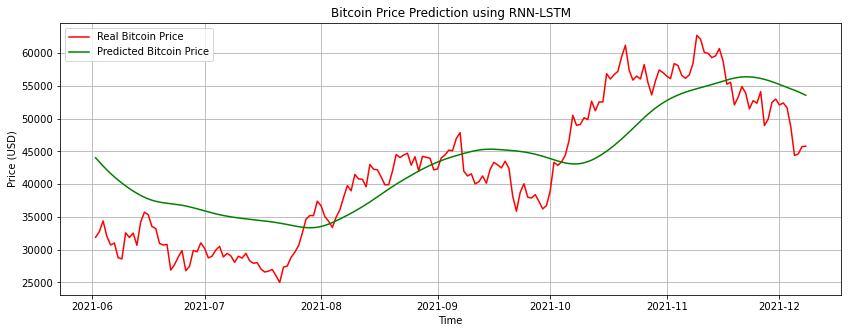

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,36687.7,38199.9,35981.1,37555.8,9689.0,44017.292969,31872.5
61,2021-06-03,37555.7,39462.3,37193.6,39187.3,10644.0,43375.027344,32740.5
62,2021-06-04,39191.4,39255.4,35659.9,36851.3,12771.0,42756.812500,34376.2
63,2021-06-05,36841.2,37887.6,34832.0,35520.0,10148.0,42169.355469,32026.0
64,2021-06-06,35518.7,36434.0,35265.3,35815.4,6220.0,41615.988281,30703.5
...,...,...,...,...,...,...,...,...
245,2021-12-04,53620.7,53847.2,42587.8,49195.2,16800.0,54551.300781,48805.5
246,2021-12-05,49196.4,49689.3,47797.8,49405.5,7203.0,54328.355469,44381.2
247,2021-12-06,49412.1,50913.3,47237.9,50562.1,8968.0,54093.968750,44596.9
248,2021-12-07,50547.4,51918.6,50070.9,50595.2,5629.0,53841.093750,45732.2


In [9]:
full_prediction_workflow(df_ta_BTC, 'Bitcoin')

In [11]:
#full_prediction_workflow(df_ta_SHIB, 'Shibainu')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            11200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_5 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_6 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

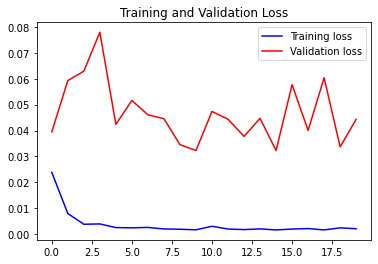

C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


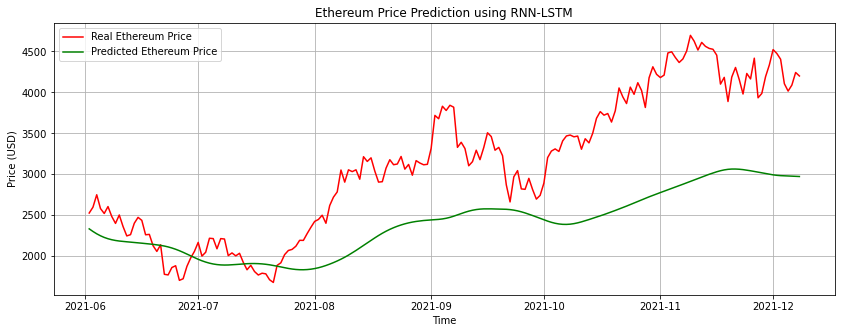

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,2633.79,2706.19,2633.79,2706.19,8546.0,2332.633545,2526.07
61,2021-06-03,2705.24,2856.64,2704.66,2856.64,7174.0,2300.665039,2597.52
62,2021-06-04,2857.02,2857.02,2638.18,2687.05,10986.0,2272.229980,2749.30
63,2021-06-05,2688.37,2742.88,2622.22,2628.85,8678.0,2247.922852,2580.65
64,2021-06-06,2628.13,2712.42,2628.13,2712.42,5298.0,2227.888428,2520.41
...,...,...,...,...,...,...,...,...
245,2021-12-04,4213.57,4237.33,3561.06,4118.06,111000.0,2980.691162,4105.85
246,2021-12-05,4123.56,4247.57,4035.80,4194.60,53633.0,2979.090820,4015.84
247,2021-12-06,4197.06,4374.22,3922.04,4352.66,72673.0,2977.368164,4089.34
248,2021-12-07,4350.79,4424.22,4259.06,4307.11,42089.0,2975.049316,4243.07


In [12]:
full_prediction_workflow(df_ta_ETH, 'Ethereum')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            11200     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_9 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_10 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

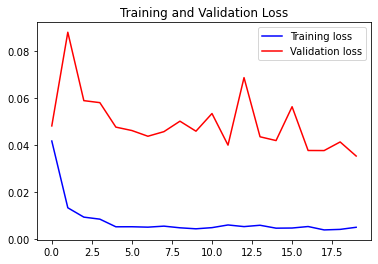

C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


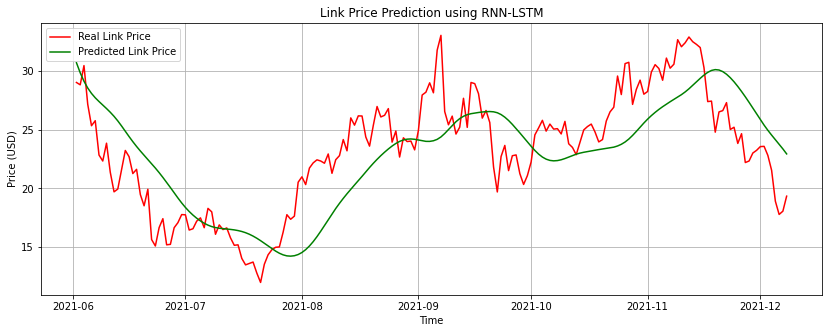

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,30.78,31.42,30.26,30.66,669000.0,30.722540,29.04
61,2021-06-03,30.58,32.36,30.38,32.17,715000.0,29.863878,28.84
62,2021-06-04,32.22,32.22,27.75,28.85,1182000.0,29.146046,30.48
63,2021-06-05,28.92,29.61,26.95,27.12,807000.0,28.568090,27.18
64,2021-06-06,27.09,27.95,27.07,27.53,410000.0,28.107834,25.35
...,...,...,...,...,...,...,...,...
245,2021-12-04,23.29,23.33,15.56,20.71,2078000.0,24.550646,21.55
246,2021-12-05,20.65,20.90,18.50,19.48,746000.0,24.162392,18.91
247,2021-12-06,19.52,19.93,17.23,19.81,851000.0,23.775223,17.78
248,2021-12-07,19.80,21.13,19.72,21.07,748000.0,23.371304,18.06


In [13]:
full_prediction_workflow(df_ta_LINK, 'Link')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            11200     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_13 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_14 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_15 (LSTM)              (None, 120)              

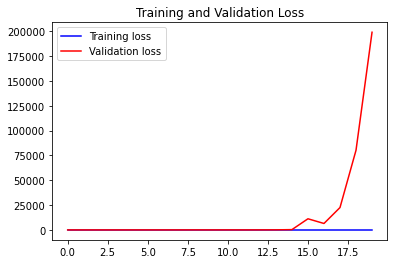

C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


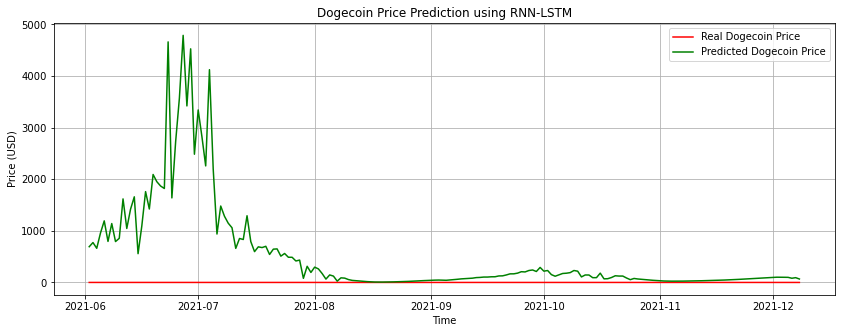

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,0.36623,0.42946,0.36386,0.42348,835000000.0,692.411194,0.364733
61,2021-06-03,0.42534,0.42852,0.38145,0.40069,507000000.0,772.943848,0.423843
62,2021-06-04,0.40068,0.40068,0.35968,0.37636,404000000.0,661.532959,0.399183
63,2021-06-05,0.37699,0.38672,0.37053,0.37181,240000000.0,957.411560,0.375493
64,2021-06-06,0.37103,0.37464,0.36849,0.37129,119000000.0,1193.283691,0.369533
...,...,...,...,...,...,...,...,...
245,2021-12-04,0.19980,0.20030,0.13320,0.17900,530000000.0,100.158295,0.198303
246,2021-12-05,0.17810,0.18070,0.16220,0.17110,138000000.0,98.879059,0.176603
247,2021-12-06,0.17140,0.18020,0.15920,0.17810,166000000.0,81.469086,0.169903
248,2021-12-07,0.17750,0.18320,0.17520,0.17620,107000000.0,92.787827,0.176003


In [14]:
full_prediction_workflow(df_ta_DOGE, 'Dogecoin')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 50)            11200     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_17 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_18 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_18 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

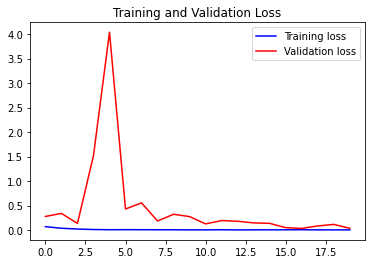

C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_9680\3579037381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


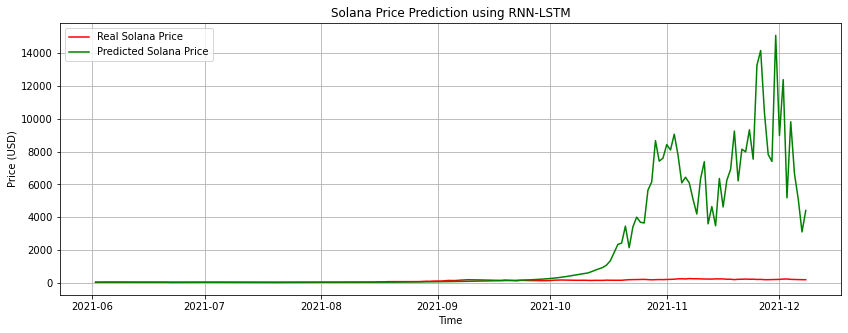

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,31.034,34.530,30.841,33.904,455000.0,41.313854,29.836
61,2021-06-03,34.000,40.166,34.000,39.600,786000.0,40.404442,32.802
62,2021-06-04,39.488,39.525,35.436,37.387,883000.0,39.514530,38.290
63,2021-06-05,37.459,42.296,37.459,39.746,865000.0,38.684113,36.261
64,2021-06-06,39.549,43.158,39.549,42.249,616000.0,37.946423,38.351
...,...,...,...,...,...,...,...,...
245,2021-12-04,211.670,212.510,170.900,201.110,489000.0,9823.734375,210.472
246,2021-12-05,201.010,204.170,182.110,196.250,248000.0,6641.132324,199.812
247,2021-12-06,196.630,197.550,176.510,193.990,282000.0,5104.879883,195.432
248,2021-12-07,193.520,203.940,187.840,190.100,194000.0,3102.685303,192.322


In [15]:
full_prediction_workflow(df_ta_SOL, 'Solana')